In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

from skll.metrics import spearman

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings

In [28]:
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,9)})
RANDOM_STATE = 420
N_JOBS=8

In [3]:
train_df = pd.read_csv("train_titanic.csv")
test_df = pd.read_csv("test_titanic.csv")

In [4]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1


In [33]:
target = 'Survived'
X = train_df.drop(target, axis = 1).values
y = train_df[target].values
features = list(train_df.drop(target, axis = 1).columns)

In [14]:
features

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'relatives', 'not_alone', 'Deck', 'Title', 'Age_Class',
       'Fare_Per_Person'],
      dtype='object')

In [6]:
pipe = Pipeline([("imputer", Imputer()),
                 ("estimator", RandomForestRegressor(random_state=RANDOM_STATE))])

In [7]:
# the hyperparamters to search over, including different imputation strategies
rf_param_space = {
    'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
    'estimator__max_features': Integer(1, 8),
    'estimator__n_estimators': Integer(50, 500), 
    'estimator__min_samples_split': Integer(2, 200),
}
# create our search object
search = BayesSearchCV(pipe, 
                        rf_param_space, 
                        cv=10,
                        n_jobs=N_JOBS, 
                        verbose=0, 
                        error_score=-9999, 
                        scoring = 'roc_auc', 
                        random_state=RANDOM_STATE,
                        return_train_score=True, 
                        n_iter=75)
# fit the model
# I get some funky warnings, possibly due to the spearman scorer,
# I choose to suppress them
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(X, y) 

In [8]:
search.best_params_

{'estimator__max_features': 8,
 'estimator__min_samples_split': 46,
 'estimator__n_estimators': 500,
 'imputer__strategy': 'median'}

In [9]:
search.best_score_

0.87697724551253764

In [10]:
estimator = search.best_estimator_.named_steps['estimator']
imputer = search.best_estimator_.named_steps['imputer']

estimator.feature_importances_

array([ 0.1171478 ,  0.27899833,  0.02482514,  0.01747926,  0.00380172,
        0.02649596,  0.01690854,  0.0672022 ,  0.00182119,  0.05588207,
        0.32154021,  0.04167733,  0.02622025])

In [34]:
import eli5

# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=features)
feat_imp_df

,feature,weight,std
0,Title,0.321540,0.288535
1,Sex,0.278998,0.273868
2,Pclass,0.117148,0.067599
3,relatives,0.067202,0.054404
4,Deck,0.055882,0.051757
5,Age_Class,0.041677,0.033189
6,Fare,0.026496,0.027905
7,Fare_Per_Person,0.026220,0.024297
8,Age,0.024825,0.024354
9,SibSp,0.017479,0.032293


In [20]:
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)



In [22]:
%matplotlib inline

/Users/alexruppelt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


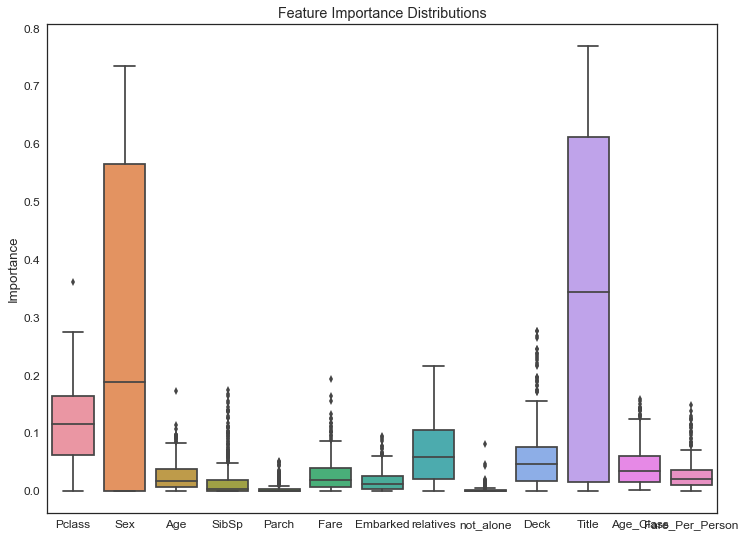

In [29]:
sns.boxplot(data=all_feat_imp_df).set(title='Feature Importance Distributions',ylabel='Importance')

In [35]:
from eli5.sklearn import PermutationImportance

# we need to impute the data first before calculating permutation importance
train_X_imp = imputer.transform(X)
# set up the met-estimator to calculate permutation importance on our training
# data
perm_train = PermutationImportance(estimator, scoring="roc_auc",
                                   n_iter=50, random_state=RANDOM_STATE)
# fit and see the permuation importances
perm_train.fit(train_X_imp, y)
eli5.explain_weights_df(perm_train, feature_names=features)

,feature,weight,std
0,Title,0.090723,0.007911
1,Sex,0.045771,0.005947
2,Pclass,0.038471,0.004495
3,Deck,0.028064,0.005232
4,Age_Class,0.016560,0.003618
5,relatives,0.013962,0.001786
6,Fare_Per_Person,0.010885,0.002845
7,Fare,0.006933,0.001829
8,Age,0.006425,0.001927
9,Embarked,0.005932,0.001409


In [36]:
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_,
                                      columns=features)

/Users/alexruppelt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[<matplotlib.text.Text at 0x112398f98>, <matplotlib.text.Text at 0x1a1b903be0>]

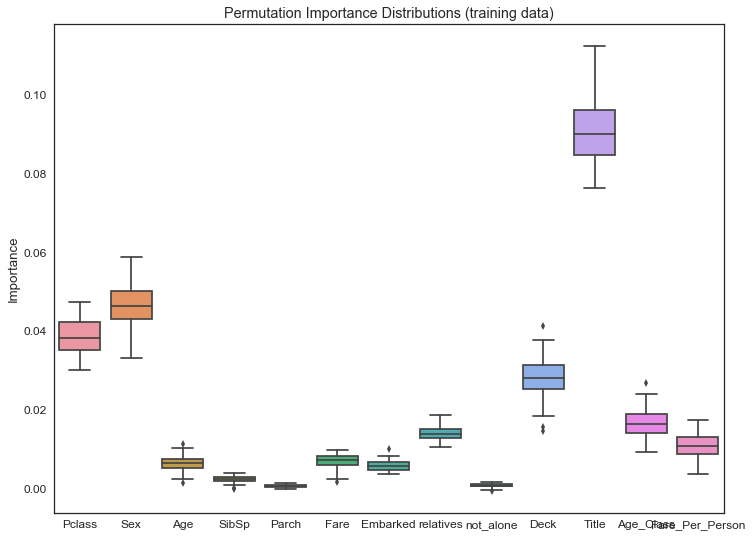

In [37]:
sns.boxplot(data=perm_train_feat_imp_df).set(title='Permutation Importance Distributions (training data)',ylabel='Importance')

# Feature Contribution

While feature importances can provide us insight into which variables a model finds valuable, they don't tell us how those features impact our model's predictions. One way to actually do that is by using the decision paths in our trees to see how much each feature changes the predictions when going from the parent to the child node. In the end we can break down these feature contributions in a linear manner such that our predictions can be interpreted like so:

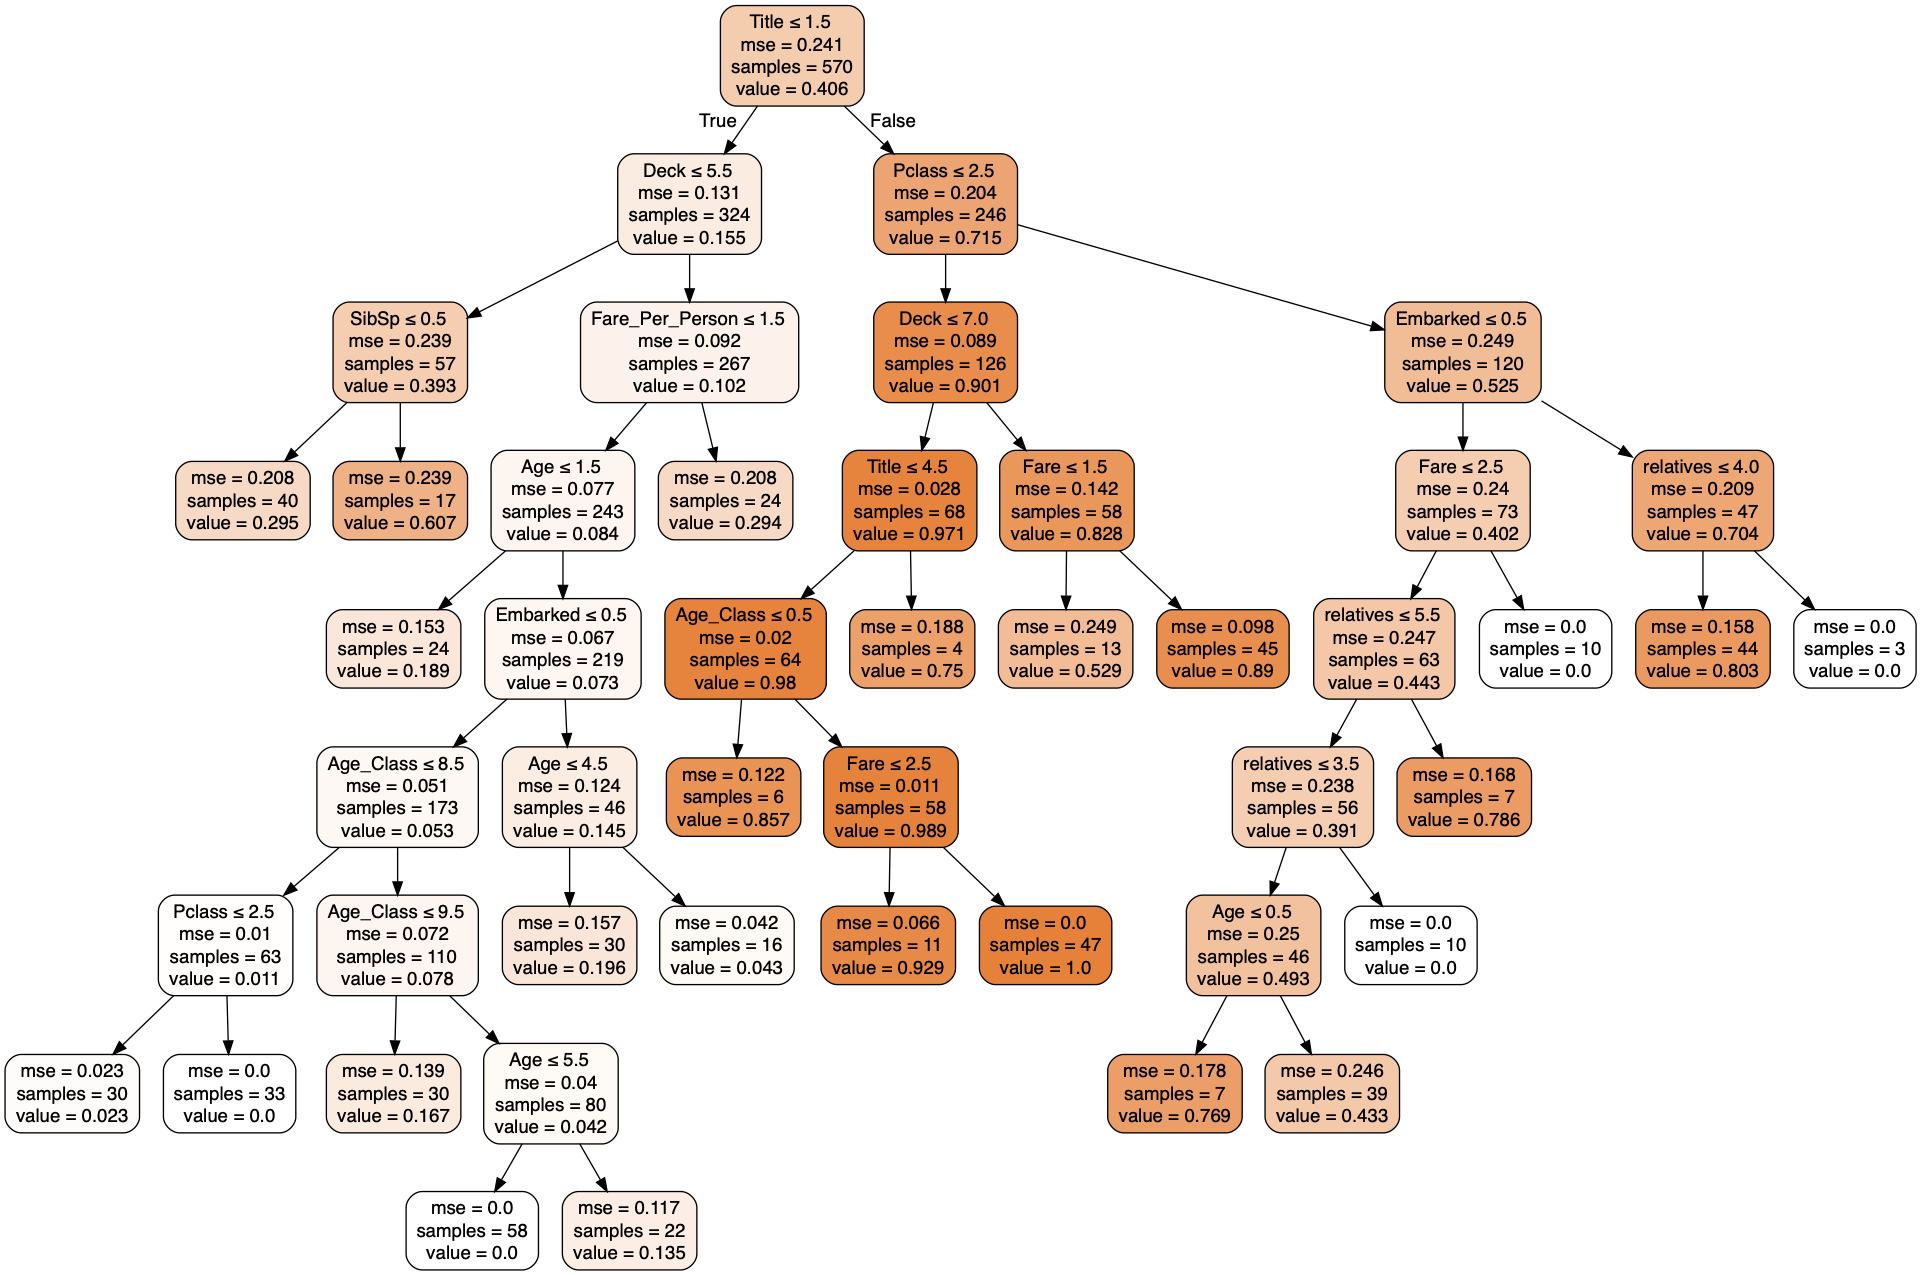

In [43]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from io import StringIO  

# source for plotting decision tree
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
# Get all trees of depth 2 in the random forest
depths2 = [tree for tree in estimator.estimators_ if tree.tree_.max_depth<=8]
# grab the first one
tree = depths2[0]
# plot the tree
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=features, 
                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [44]:
from concurrent.futures import ProcessPoolExecutor

def multiproc_iter_func(max_workers, an_iter, func, item_kwarg, **kwargs):
    """
    A helper functions that applies a function to each item in an iterable using
    multiple processes. 'item_kwarg' is the keyword argument for the item in the
    iterable that we pass to the function.
    """
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_results = [executor.submit(func, **{item_kwarg: item}, **kwargs)
                          for item in an_iter]

        results = [future.result() for future in future_results]
        
    return results

In [47]:
# Contibrutions for training set predictions
# construct a list of all contributions for the entire train set
train_expl_list = multiproc_iter_func(N_JOBS, train_X_imp, 
                                      eli5.explain_prediction_df, 'doc',
                                      estimator=estimator, 
                                      feature_names=features)
# concatenate them into 1 large dataframe, with the proper player name as an
# index
train_expl_df = pd.concat(train_expl_list, keys=train_df.index, 
                          names=['index'])

In [53]:
X_test = test_df.drop("PassengerId", axis = 1)
test_X_imp = imputer.transform(X_test)
# now repeat what we did with the training data on the test data
test_expl_list = multiproc_iter_func(N_JOBS, test_X_imp, 
                                     eli5.explain_prediction_df, 'doc', 
                                     estimator=estimator,
                                     feature_names=features)

test_expl_df = pd.concat(test_expl_list, keys=test_df.index, 
                         names=['index'])

In [56]:
# Double check that the sums of contributions equal the actual predictions
y_pred_sums = test_expl_df.groupby('index').weight.sum()

In [ ]:
# Feature Contributions

/Users/alexruppelt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


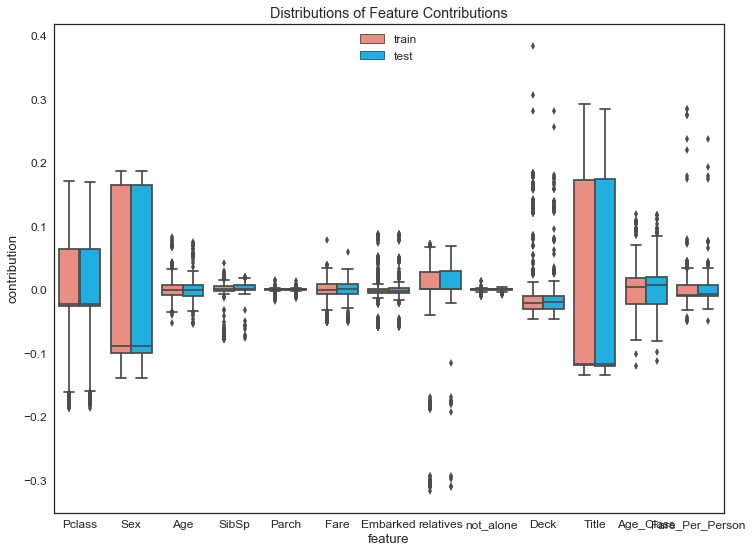

In [57]:
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
test_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
train_expl_df['data'] = 'train'
test_expl_df['data'] = 'test'
train_test_expl_df = pd.concat([train_expl_df, test_expl_df])
sns.boxplot(x='feature', y='contribution', hue='data', order=features,
            data=train_test_expl_df.loc[train_test_expl_df.feature!=''],
            palette={'train': 'salmon', 
                     'test':'deepskyblue'})
plt.legend(loc=9)
plt.title('Distributions of Feature Contributions');

# PDP and ICE plots

In [60]:
from pycebox.ice import ice, ice_plot

# pcyebox likes the data to be in a DataFrame so let's create one with our imputed data
# we first need to impute the missing data
train_X_imp_df = pd.DataFrame(train_X_imp, columns=features)

In [65]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=3, 
                  ncols=3, figsize=(12, 12), sharex=False, sharey=True, 
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the 
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.distplot(data_df[f], ax=ax, hist=False, kde=False, 
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()
        
    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

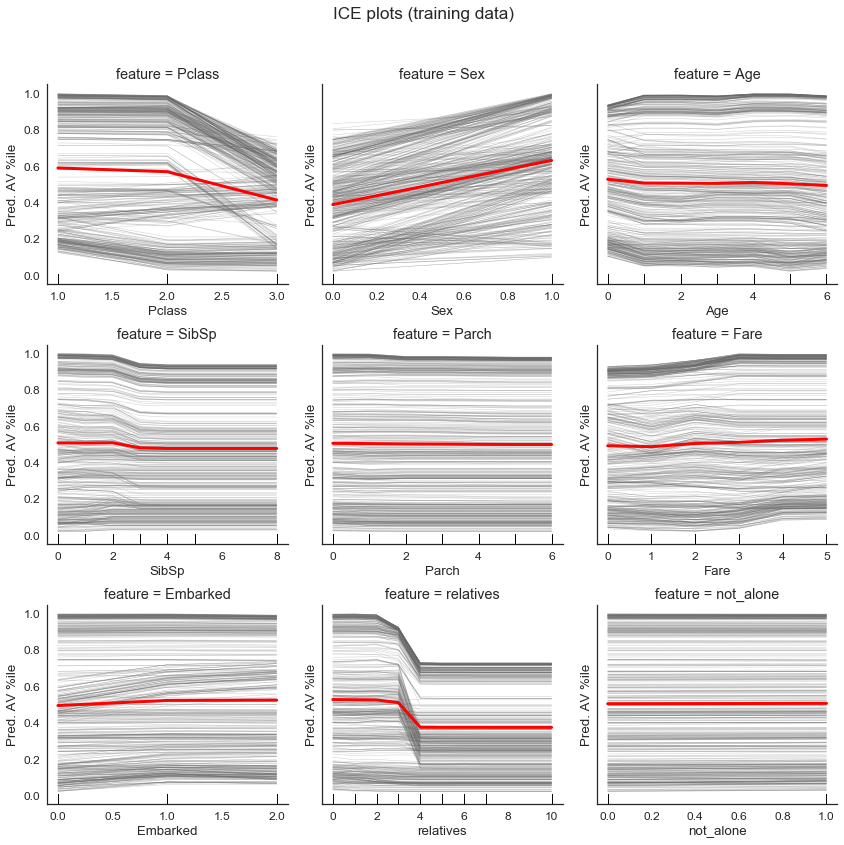

In [66]:
# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=train_X_imp_df, column=feat, predict=estimator.predict) 
                 for feat in features}

fig = plot_ice_grid(train_ice_dfs, train_X_imp_df, features,
                    ax_ylabel='Pred. AV %ile', alpha=0.3, plot_pdp=True,
                    pdp_kwargs={'c': 'red', 'linewidth': 3},
                    linewidth=0.5, c='dimgray')
fig.tight_layout()
fig.suptitle('ICE plots (training data)')
fig.subplots_adjust(top=0.89)

# Lime

In [68]:
import lime
from lime.lime_tabular import LimeTabularExplainer

In [108]:
# create the explainer by passing our training data, 
# setting the correct modeling mode, pass in feature names and
# make sure we don't discretize the continuous features
explainer = LimeTabularExplainer(train_X_imp_df, mode='regression', 
                                 feature_names=features, 
                                 random_state=RANDOM_STATE, 
                                 discretize_continuous=False) 

In [109]:
test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)
# the number of features to include in our predictions
num_features = len(features)
# the index of the instance we want to explaine
exp_idx = 10
exp = explainer.explain_instance(test_X_imp_df.iloc[exp_idx,:].values, 
                                 estimator.predict, num_features=num_features)

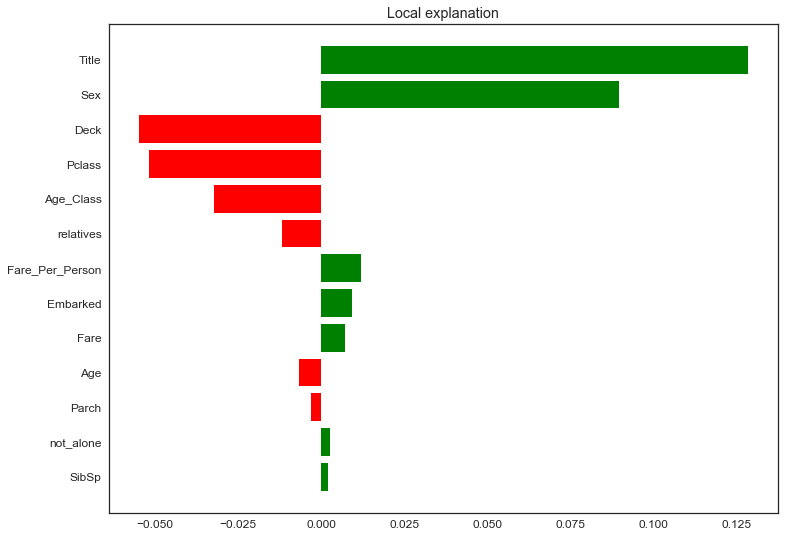

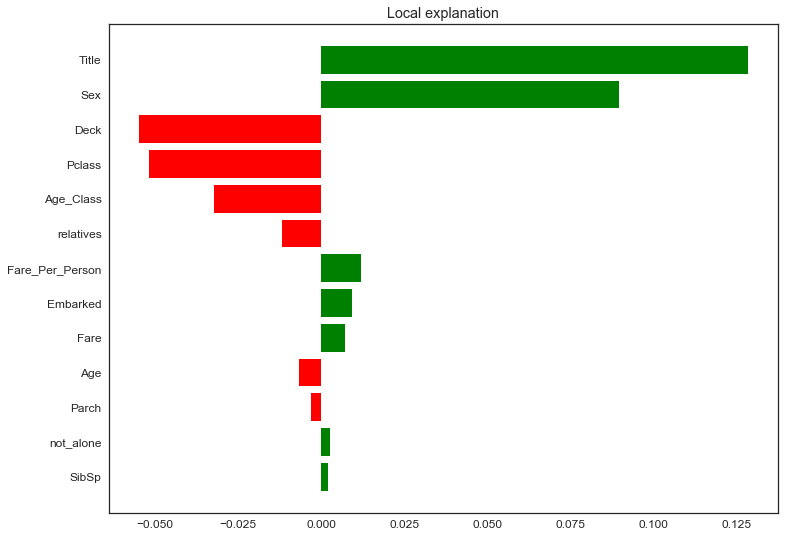

In [110]:
exp.as_pyplot_figure()

In [111]:
exp.show_in_notebook()

# SHAP

In [106]:

import shap

X = train_df.drop(target, axis = 1)

# load JS visualization code to notebook
shap.initjs()
import lightgbm
model = lightgbm.train({"learning_rate": 0.01}, lightgbm.Dataset(X, y))
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[10,:], X.iloc[10,:])

In [98]:
shap.force_plot(explainer.expected_value, shap_values, X)

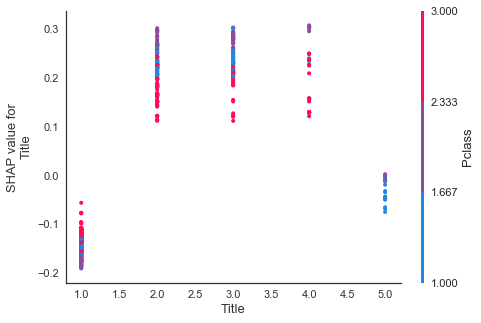

In [101]:
shap.dependence_plot("Title", shap_values, X)

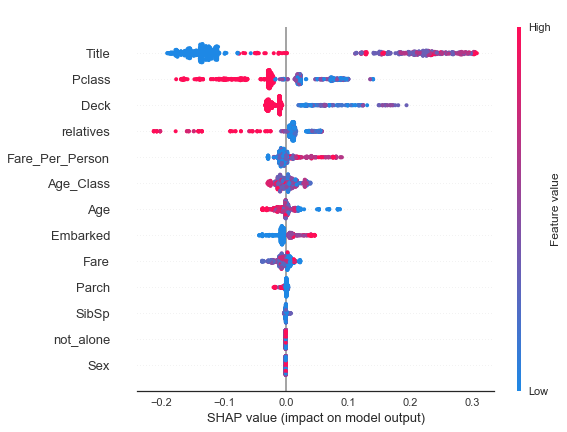

In [102]:
shap.summary_plot(shap_values, X)